<img src="../docs/_static/logo-rsm.png" align="right" width="200">


# Part 3: Our first neural network with `PyTorch`

This notebook implements our first NN in `PyTorch`:
1. Create a data set that requires a nonlinear decision boundary (spiral data)
cross_entropyImplement inference using `torch.nn`
1. Evaluate model
1. Vary architecture

Check out this http://playground.tensorflow.org/ to experiment quickly with some simple features, hyperparameters and architectures.

In [1]:
import numpy as np
import sklearn.metrics
import torch
from sklearn.model_selection import train_test_split
from torch.nn import Linear, Module, ModuleList
from torch.nn.functional import binary_cross_entropy_with_logits, relu
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from src.common import yaml_load
from src.nn import generate_data, plot_spiral, score

In [2]:
config = yaml_load("../configs/config.yaml")

<br>

## Data

In [3]:
xy_lims = (-25, 25)

In [4]:
X, y = generate_data(N=config["data"]["N"], n_loops=3.5)

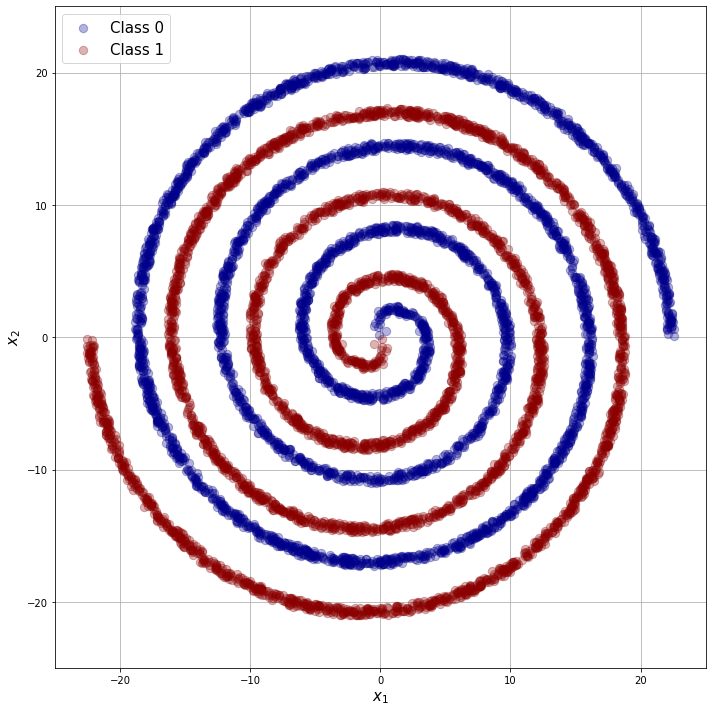

In [5]:
plot_spiral(X, y, xlim=xy_lims, ylim=xy_lims)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=config["data"]["test"]["batch_size"],
    random_state=config["seed"],
)

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    test_size=config["data"]["valid"]["batch_size"],
    random_state=config["seed"],
)

<br>

## Our first `torch` model

In [8]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_valid = torch.tensor(x_valid)
y_valid = torch.tensor(y_valid)
x_test = torch.tensor(x_test)

In [9]:
ds_train = TensorDataset(x_train, y_train)
dl_train = DataLoader(ds_train, **config["data"]["train"])

In [10]:
class Trainer:
    def __init__(self, train, validation, model):
        self.train = train
        self.validation = validation
        self.model = model
        self.opt = Adam(self.model.parameters())

    def fit(self, n_epochs):
        for epoch in range(n_epochs):
            self.model.train()
            for xb, yb in self.train:
                self.opt.zero_grad()
                loss_train = binary_cross_entropy_with_logits(
                    self.model(xb).flatten(), yb
                )
                loss_train.backward()
                self.opt.step()

            self.model.eval()
            with torch.no_grad():
                loss_valid = binary_cross_entropy_with_logits(
                    self.model(self.validation[0]).flatten(), self.validation[1]
                )

    def predict(self, x):
        return torch.sigmoid(self.model(x))

<br>

## Feed-forward with 1 layer

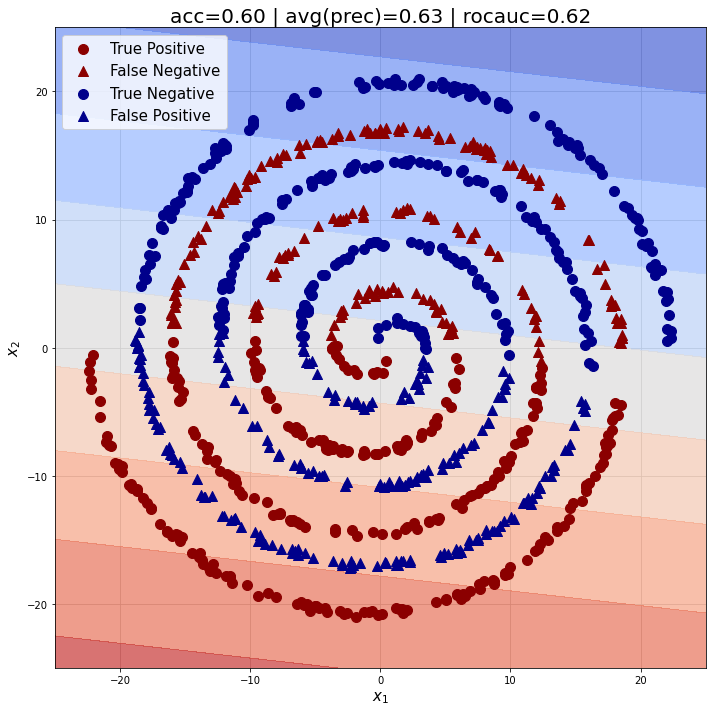

In [11]:
class Net0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h0 = torch.nn.Linear(2, 1)

    def forward(self, xb):
        return self.h0(xb).flatten()


torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

trainer_0 = Trainer(dl_train, [x_valid, y_valid], Net0())
trainer_0.fit(n_epochs=config["trainer"]["epochs"])

score(x_test, y_test, trainer_0, xy_lims, xy_lims)

<br>

## Feed-forward with 3 layers

Why is the model not getting better?

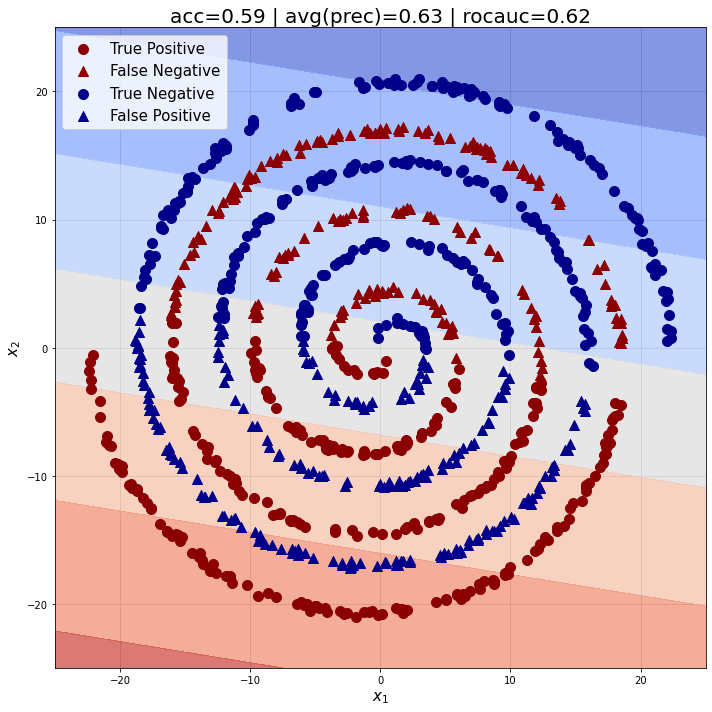

In [12]:
class Net1(Module):
    def __init__(self):
        super().__init__()
        self.h0 = Linear(2, 12)
        self.h1 = Linear(12, 6)
        self.h2 = Linear(6, 1)

    def forward(self, xb):
        xb = self.h0(xb)
        xb = self.h1(xb)
        xb = self.h2(xb)
        return xb.flatten()


torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

trainer_1 = Trainer(dl_train, [x_valid, y_valid], Net1())
trainer_1.fit(n_epochs=config["trainer"]["epochs"])

score(x_test, y_test, trainer_1, xy_lims, xy_lims)

<br>

## Multilayer perceptron

We need non-linearities, i.e., activation functions!

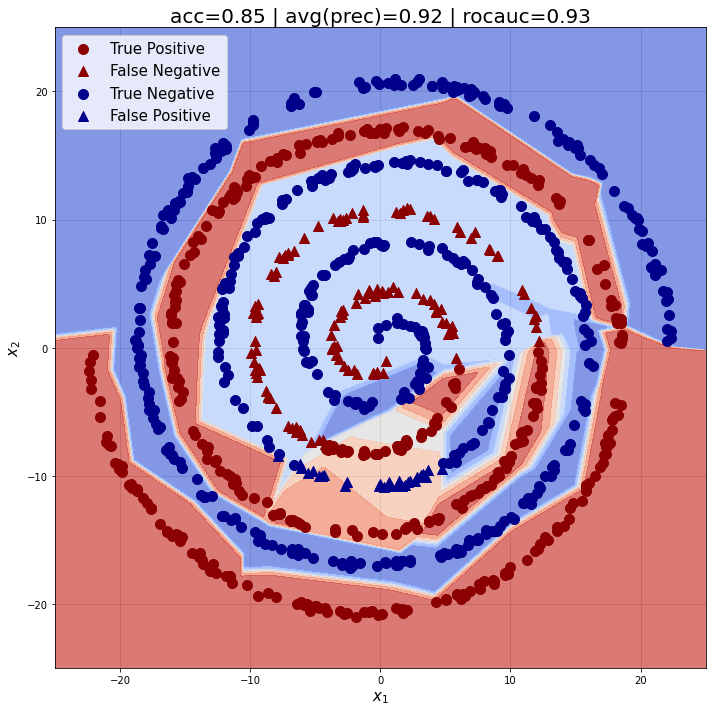

In [13]:
class Net2(Module):
    def __init__(self):
        super().__init__()
        self.h0 = Linear(2, 12)
        self.h1 = Linear(12, 6)
        self.h2 = Linear(6, 1)

    def forward(self, xb):
        xb = self.h0(xb)
        xb = relu(xb)
        xb = self.h1(xb)
        xb = relu(xb)
        xb = self.h2(xb)
        return xb.flatten()


torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

trainer_2 = Trainer(dl_train, [x_valid, y_valid], Net2())
trainer_2.fit(n_epochs=config["trainer"]["epochs"])

score(x_test, y_test, trainer_2, xy_lims, xy_lims)

<br> 

## Generalize multilayer perceptron

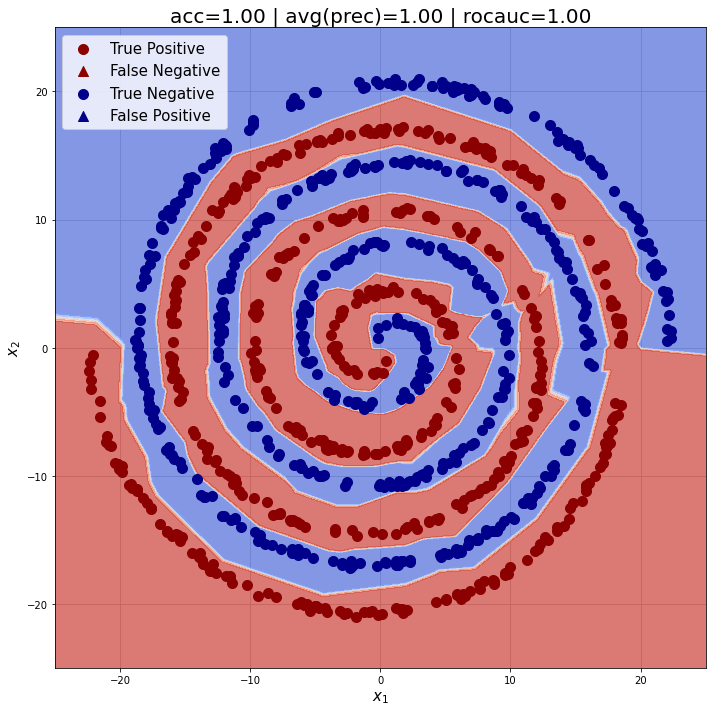

In [14]:
class Net(Module):
    def __init__(self, n_features, layers):
        super().__init__()
        self.hidden = ModuleList()
        layers_in = [n_features] + config["model"]["layers"]
        layers_out = config["model"]["layers"] + [1]
        for i in range(len(layers) + 1):
            self.hidden.append(Linear(layers_in[i], layers_out[i]))

    def forward(self, xb):
        for i, h in enumerate(self.hidden):
            xb = h(xb)
            if i < (len(self.hidden) - 1):
                xb = relu(xb)
        return xb.flatten()


torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

trainer = Trainer(dl_train, [x_valid, y_valid], Net(**config["model"]))
trainer.fit(n_epochs=config["trainer"]["epochs"])

score(x_test, y_test, trainer, xy_lims, xy_lims)

<br>

## Do you see the problem with the decision boundary?

In [15]:
r = np.sqrt((X**2).sum(axis=1))
is_train = r <= 16.1
x_train = X[is_train, :]
y_train = y[is_train]
x_test = X[~is_train, :]
y_test = y[~is_train]

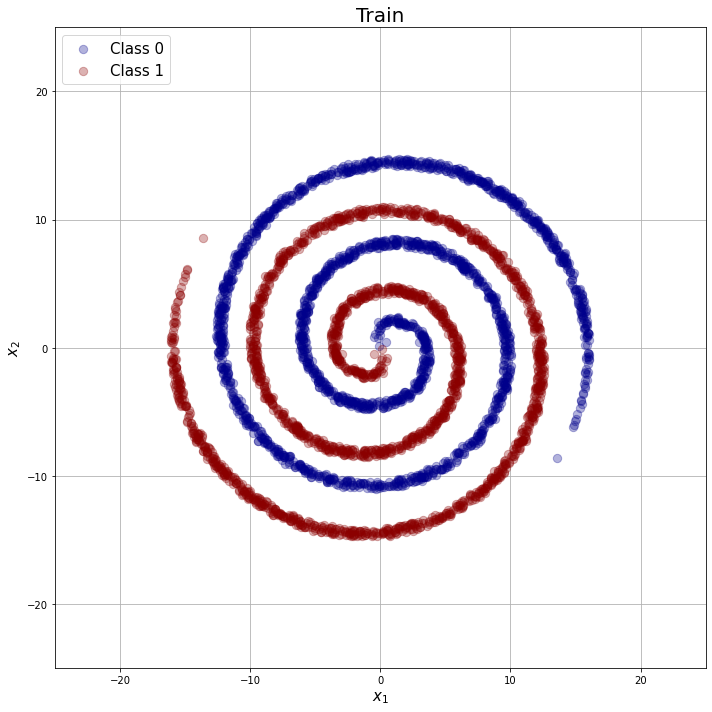

In [16]:
plot_spiral(x_train, y_train, xlim=xy_lims, ylim=xy_lims, title="Train")

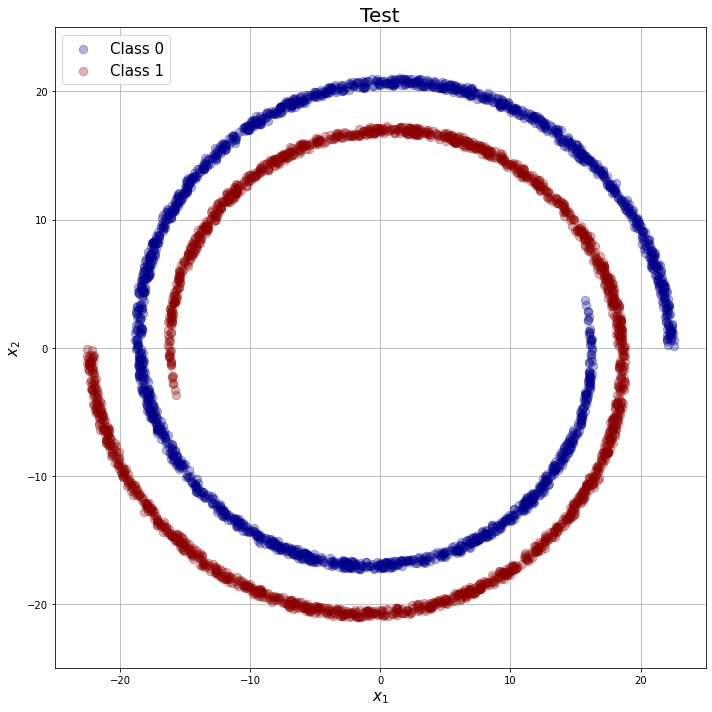

In [17]:
plot_spiral(x_test, y_test, xlim=xy_lims, ylim=xy_lims, title="Test")

In [18]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test)

In [19]:
ds_train = TensorDataset(x_train, y_train)
dl_train = DataLoader(ds_train, **config["data"]["train"])

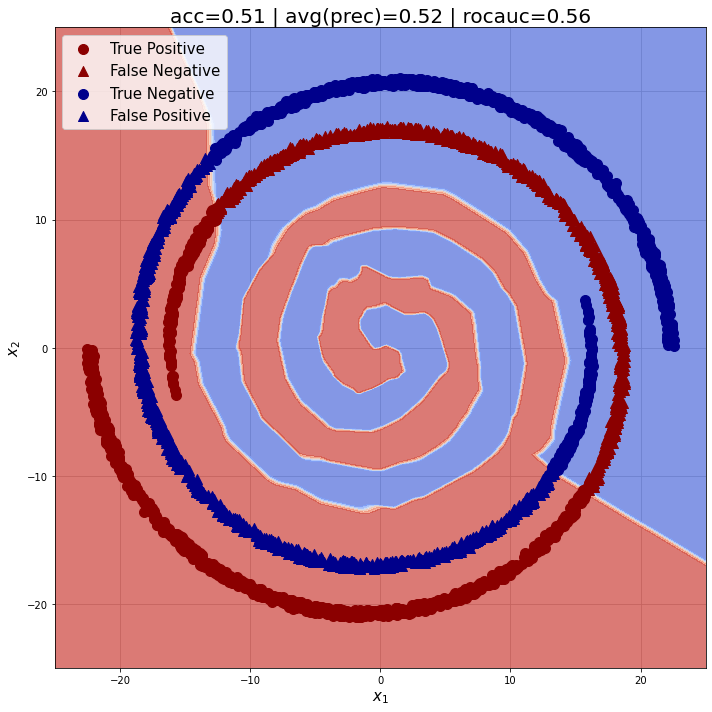

In [20]:
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

model = Net(**config["model"])
trainer = Trainer(dl_train, [x_valid, y_valid], model)
trainer.fit(n_epochs=config["trainer"]["epochs"])

score(x_test, y_test, trainer, xy_lims, xy_lims)

## Discussion: How can we fix this?

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
Rotterdam School of Management <br>

www.github.com/sbstn-gbl <br>
www.sebastiangabel.com